Here we have the setup for our model, which includes both an LSTM and XGBoost classifier to improve performance. It is quite difficult to extract features from the dataset to consistently detect frauds, simply due to the nature of the dataset with only 0.001% of the transactions being frauds. Nevertheless, and ensemble model with LSTM+XGBoost provides a respectable performance

2025-08-27 11:15:37.046810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-27 11:15:37.046859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-27 11:15:37.046873: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


X_seq: (142857, 7, 80) y_seq: (142857,)
Train: (91428, 7, 80) Val: (22857, 7, 80) Test: (28572, 7, 80)
Train class counts: [91338    90]
Resampled train (LSTM): (182676, 7, 80) class counts: [91338 91338]
Epoch 1/40
714/714 - 33s - loss: 0.0041 - roc_auc: 0.9902 - pr_auc: 0.9894 - precision: 0.8560 - recall: 0.9996 - val_loss: 0.0045 - val_roc_auc: 0.6918 - val_pr_auc: 0.0371 - val_precision: 0.0278 - val_recall: 0.2174 - lr: 0.0010 - 33s/epoch - 46ms/step
Epoch 2/40
714/714 - 28s - loss: 5.1130e-04 - roc_auc: 0.9996 - pr_auc: 0.9994 - precision: 0.9858 - recall: 0.9998 - val_loss: 0.0045 - val_roc_auc: 0.6612 - val_pr_auc: 0.0447 - val_precision: 0.0577 - val_recall: 0.1304 - lr: 0.0010 - 28s/epoch - 40ms/step
Epoch 3/40
714/714 - 28s - loss: 8.5291e-05 - roc_auc: 0.9999 - pr_auc: 0.9999 - precision: 0.9982 - recall: 1.0000 - val_loss: 0.0046 - val_roc_auc: 0.7084 - val_pr_auc: 0.0702 - val_precision: 0.0301 - val_recall: 0.2174 - lr: 0.0010 - 28s/epoch - 40ms/step
Epoch 4/40
714/714 

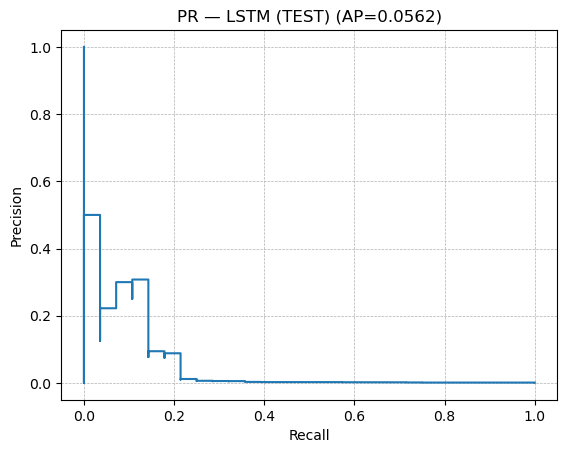

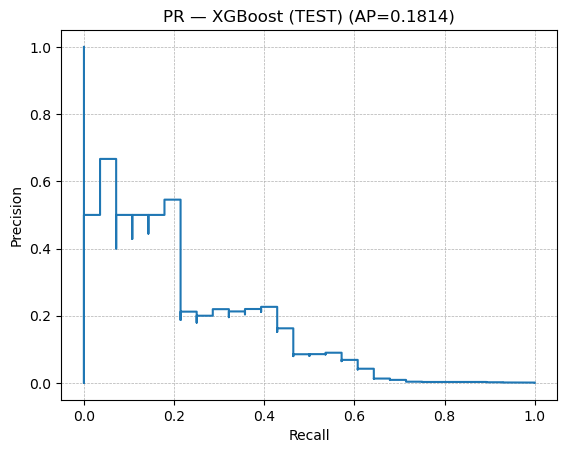

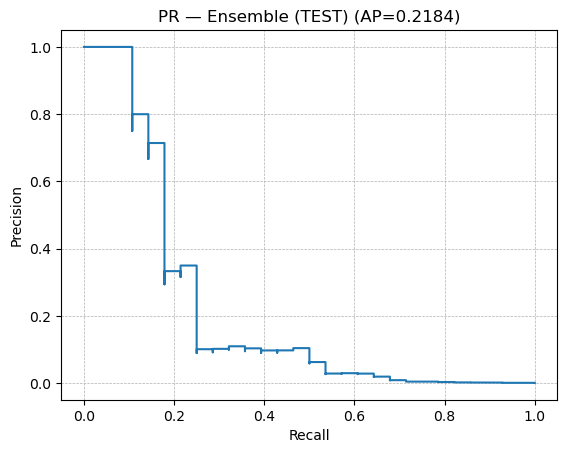

In [1]:

import os, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
np.random.seed(42); random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)

# XGBoost baseline 
from xgboost import XGBClassifier

# Configuration setup
DATA_PATH        = "transactions_processed.npz"
SEQUENCE_LENGTH  = 7
TEST_SIZE        = 0.20
VAL_SIZE         = 0.20

# LSTM training
EPOCHS           = 40
BATCH_SIZE       = 256
USE_FOCAL_LOSS   = True
TARGET_POS_RATIO = 1.0      # oversample positives to roughly 1:1 by sequence due to very low fraud samples

# Thresholding
TARGET_RECALL    = 0.70
COST_FN          = 10.0     # false negative cost
COST_FP          = 1.0      # false positive cost

# Help functions
def focal_loss(gamma: float = 3.0, alpha: float = 0.9):
    """Binary focal loss (for extreme imbalance)."""
    def _loss(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        w  = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        return tf.reduce_mean(-w * tf.pow(1 - pt, gamma) * tf.math.log(pt))
    return _loss

def make_sequences(X: np.ndarray, y: np.ndarray, seq_len: int):
    """Non-overlapping sequences, label by last timestep."""
    n = X.shape[0]
    usable = (n // seq_len) * seq_len
    X = X[:usable]
    y = y[:usable]
    X_seq = X.reshape(-1, seq_len, X.shape[1])
    y_seq = y.reshape(-1, seq_len)[:, -1].astype(int)
    return X_seq, y_seq

def random_oversample_sequences(X_seq, y_seq, target_pos_ratio=1.0, rng=np.random):
    """Oversample positive sequences to reach target pos:neg ratio."""
    pos_idx = np.where(y_seq == 1)[0]
    neg_idx = np.where(y_seq == 0)[0]
    n_pos, n_neg = len(pos_idx), len(neg_idx)
    if n_pos == 0:
        return X_seq, y_seq
    desired_pos = int(math.ceil(target_pos_ratio * n_neg))
    if desired_pos <= n_pos:
        sel_pos = pos_idx
    else:
        extra = desired_pos - n_pos
        sel_pos = np.concatenate([pos_idx, rng.choice(pos_idx, size=extra, replace=True)])
    idx = np.concatenate([neg_idx, sel_pos])
    rng.shuffle(idx)
    return X_seq[idx], y_seq[idx]

def sweep_thresholds(y_true, y_proba, resolution=1500):
    thresholds = np.linspace(1e-6, 0.999999, resolution)
    rows = []
    for t in thresholds:
        yp = (y_proba >= t).astype(int)
        p  = precision_score(y_true, yp, zero_division=0)
        r  = recall_score(y_true, yp, zero_division=0)
        f1 = 0.0 if (p+r)==0 else 2*p*r/(p+r)
        rows.append({"threshold": t, "precision": p, "recall": r, "f1": f1})
    return pd.DataFrame(rows)

def pick_cost_min_threshold(y_true, y_proba, resolution=3000, cost_fn=COST_FN, cost_fp=COST_FP):
    thresholds = np.linspace(1e-6, 0.999999, resolution)
    best_t, best_c = None, float("inf")
    for t in thresholds:
        yp = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        cost = cost_fn*fn + cost_fp*fp
        if cost < best_c:
            best_c, best_t = cost, t
    return float(best_t), float(best_c)

def pick_threshold_for_target_recall(y_true, y_proba, target=TARGET_RECALL, resolution=3000):
    df = sweep_thresholds(y_true, y_proba, resolution)
    cand = df[df["recall"] >= target]
    if len(cand) == 0:
        return float(df.iloc[df["f1"].idxmax()]["threshold"])
    # highest threshold that still reaches target recall
    cand = cand.sort_values("threshold")
    return float(cand["threshold"].max())

def evaluate_at(y_true, y_proba, thr, title):
    yp = (y_proba >= thr).astype(int)
    print(f"\n=== {title} (threshold={thr:.6f}) ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, yp))
    print("\nClassification Report:")
    print(classification_report(y_true, yp, digits=4))
    return {
        "precision": precision_score(y_true, yp, zero_division=0),
        "recall": recall_score(y_true, yp, zero_division=0),
        "f1": f1_score(y_true, yp, zero_division=0),
    }

def summarize_split(name, y_true, y_prob):
    roc = roc_auc_score(y_true, y_prob)
    pr  = average_precision_score(y_true, y_prob)
    print(f"{name} ROC AUC: {roc:.4f} | PR AUC: {pr:.4f}")
    return roc, pr

def build_lstm(input_timesteps, num_features):
    return Sequential([
        LSTM(128, input_shape=(input_timesteps, num_features), return_sequences=True),
        Dropout(0.30),
        LSTM(64),
        Dropout(0.20),
        Dense(1, activation="sigmoid"),
    ])

# Data loading and train-test split
data = np.load(DATA_PATH)
X_raw, y_raw = data["X"], data["y"].astype(int)
X_seq, y_seq = make_sequences(X_raw, y_raw, SEQUENCE_LENGTH)
print("X_seq:", X_seq.shape, "y_seq:", y_seq.shape)


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_seq, y_seq, test_size=TEST_SIZE, stratify=y_seq, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, stratify=y_train_full, random_state=42
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train class counts:", np.bincount(y_train))

# Oversampled LSTM
X_train_res, y_train_res = random_oversample_sequences(
    X_train, y_train, target_pos_ratio=TARGET_POS_RATIO, rng=np.random.default_rng(42)
)
print("Resampled train (LSTM):", X_train_res.shape, "class counts:", np.bincount(y_train_res))

lstm_model = build_lstm(SEQUENCE_LENGTH, X_seq.shape[2])
metrics = [
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc",  curve="PR"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]
loss_fn = focal_loss(gamma=3.0, alpha=0.9) if USE_FOCAL_LOSS else "binary_crossentropy"
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=loss_fn, metrics=metrics)

callbacks = [
    EarlyStopping(monitor="val_pr_auc", mode="max", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

lstm_model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

y_val_lstm  = lstm_model.predict(X_val,  batch_size=1024).ravel()
y_test_lstm = lstm_model.predict(X_test, batch_size=1024).ravel()
summarize_split("VAL (LSTM)",  y_val,  y_val_lstm)
summarize_split("TEST (LSTM)", y_test, y_test_lstm)

# Baseline XGBoost
X_train_tab = X_train[:, -1, :]
X_val_tab   = X_val[:,   -1, :]
X_test_tab  = X_test[:,  -1, :]

# Scaling with original sample ratios before oversampling
n_pos = max(1, int(np.sum(y_train == 1)))
n_neg = max(1, int(np.sum(y_train == 0)))
spw   = n_neg / n_pos

xgb = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    eval_metric="aucpr",
    scale_pos_weight=spw,
    tree_method="hist",
    random_state=42,
    n_jobs=0
)
xgb.fit(X_train_tab, y_train, eval_set=[(X_val_tab, y_val)], verbose=False)

y_val_xgb  = xgb.predict_proba(X_val_tab)[:, 1]
y_test_xgb = xgb.predict_proba(X_test_tab)[:, 1]
summarize_split("VAL (XGB)",  y_val,  y_val_xgb)
summarize_split("TEST (XGB)", y_test, y_test_xgb)


# Ensemble (simple average 50/50)
y_val_ens  = 0.5 * y_val_lstm  + 0.5 * y_val_xgb
y_test_ens = 0.5 * y_test_lstm + 0.5 * y_test_xgb
summarize_split("VAL (Ensemble)",  y_val,  y_val_ens)
summarize_split("TEST (Ensemble)", y_test, y_test_ens)


# Thresholds on validation (use ensemble)
sweep_ens = sweep_thresholds(y_val, y_val_ens, resolution=1500)
best_f1_row = sweep_ens.iloc[sweep_ens["f1"].idxmax()]
thr_bestf1  = float(best_f1_row["threshold"])
thr_cost, min_cost = pick_cost_min_threshold(y_val, y_val_ens, resolution=3000, cost_fn=COST_FN, cost_fp=COST_FP)
thr_tgtrec  = pick_threshold_for_target_recall(y_val, y_val_ens, target=TARGET_RECALL, resolution=3000)

print("\nChosen thresholds (Ensemble):")
print(f"- Best-F1 on VAL: {thr_bestf1:.6f} (F1={best_f1_row['f1']:.4f}, P={best_f1_row['precision']:.4f}, R={best_f1_row['recall']:.4f})")
print(f"- Cost-min on VAL: {thr_cost:.6f} (min cost={min_cost:.2f}, FN={COST_FN}, FP={COST_FP})")
print(f"- Target recall ≥ {TARGET_RECALL:.2f}: {thr_tgtrec:.6f}")


# Evaluate ensemble on TEST at those thresholds
evaluate_at(y_test, y_test_ens, thr_bestf1, "TEST (Ensemble) Best-F1")
evaluate_at(y_test, y_test_ens, thr_cost,   "TEST (Ensemble) Cost-Optimal")
evaluate_at(y_test, y_test_ens, thr_tgtrec, "TEST (Ensemble) Target-Recall")


# (Optional) PR curves
try:
    import matplotlib.pyplot as plt

    def plot_pr(y_true, y_proba, title):
        p, r, _ = precision_recall_curve(y_true, y_proba)
        ap = average_precision_score(y_true, y_proba)
        plt.figure()
        plt.step(r, p, where="post")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{title} (AP={ap:.4f})")
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.show()

    plot_pr(y_test, y_test_lstm, "PR — LSTM (TEST)")
    plot_pr(y_test, y_test_xgb,  "PR — XGBoost (TEST)")
    plot_pr(y_test, y_test_ens,  "PR — Ensemble (TEST)")
except Exception as e:
    print("Skipping PR plots:", e)


From the above graphs, it is clear that precision falls as recall increases, for all the model permutations. Precisions is how often the model raises an alert for fraud, and how many of those are actually fraud (In the best case for ensemble, 5/8 are actually frauds so a respectable total, but 23 of the frauds were missed). For recall, it is the ratio of how many of the actual frauds were caught (in the best case for recall, 22 of the 28 frauds were found, but thats from a huge number of alerts, causing low precision) 

Below, we have code to save our trained model, with both LSTM and XGboost parameters alongside the optimal tresholds. Here the values are set to optimize PR-AUC (Area Under the Precision–Recall Curve), which is the best KPI when considering rare-event case detections (such as fraud).

In [2]:
import os, json

os.makedirs("models", exist_ok=True)

# Save LSTM (Keras v3 native format)
lstm_model.save("models/lstm.keras")  # don't pass extra kwargs (like options)

# Save XGBoost
xgb.save_model("models/xgb.json")

# Save ensemble config & (optional) thresholds
ensemble_config = {
    "sequence_length": 7,                
    "num_features":   X_seq.shape[2],   
    "weights": {"lstm": 0.5, "xgb": 0.5},
    "thresholds": {
        "best_f1":       0.472982,
        "cost_min":      0.472491,
        "target_recall": 0.003335
    }
}
with open("models/ensemble_config.json", "w") as f:
    json.dump(ensemble_config, f, indent=2)

print("Saved: models/lstm.keras, models/xgb.json, models/ensemble_config.json")

Saved: models/lstm.keras, models/xgb.json, models/ensemble_config.json
